<a href="https://colab.research.google.com/github/GerasimovNE/Unet/blob/main/34_4_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%93%D0%B5%D1%80%D0%B0%D1%81%D0%B8%D0%BC%D0%BE%D0%B2_%D0%9D%D0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

автокодировщик, сегментация изображений
архитектура Unet++

загрузка датасета  covid19-radiography-database


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gunsmoker
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:07<00:00, 103MB/s]


In [ ]:
import os
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling, Dropout
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from keras.models import Model, Sequential
from keras.preprocessing.image import  load_img
import numpy as np
from keras.optimizers import Adam
import tensorflow_datasets as tfds
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
PATH_IMAGES = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/"
PATH_MASKS = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/"
IMAGE_SIZE = (160,160)
NUM_CLASSES = 2
BATCH_SIZE = 64

In [ ]:
images = os.listdir(PATH_IMAGES)
print(len(images))

10192


разобьём на выборки

In [ ]:
train = images[:6000]
valid = images[6000:8000]
test = images[8000:8010]

загрузка изабражения

In [ ]:
def load_image(image, path):
  input_image = tf.keras.utils.load_img(f"{path}{image}", target_size=IMAGE_SIZE, color_mode='grayscale')
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return np.array(input_image).reshape(*IMAGE_SIZE,1)

загрузка маски

In [ ]:
def load_mask(mask,path):
  mask_ = tf.keras.utils.load_img(f"{path}{mask}", target_size=IMAGE_SIZE, color_mode='grayscale')
  mask_ = to_categorical(np.array(mask_)/255,num_classes=NUM_CLASSES)
  return np.array(mask_)

функция генератор

In [ ]:
def image_generator(images):
  for image in images:
    x = load_image(image,PATH_IMAGES)
    y = load_mask(image,PATH_MASKS)
    yield x,y

соберем генераторы для train и valid выборок

In [ ]:
train_data = tf.data.Dataset.from_generator(
    lambda : image_generator(train),
    output_signature =(
          tf.TensorSpec(shape=(*IMAGE_SIZE,1), dtype=tf.float32),
          tf.TensorSpec(shape=(*IMAGE_SIZE,NUM_CLASSES), dtype=tf.float32)))

train_data = train_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(1)


In [ ]:
valid_data = tf.data.Dataset.from_generator(
    lambda : image_generator(valid),
    output_signature =(
          tf.TensorSpec(shape=(*IMAGE_SIZE,1), dtype=tf.float32),
          tf.TensorSpec(shape=(*IMAGE_SIZE,NUM_CLASSES), dtype=tf.float32)))

valid_data = valid_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(1)


In [ ]:
train_data.element_spec


(TensorSpec(shape=(None, 160, 160, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 160, 160, 2), dtype=tf.float32, name=None))

операция свертки

In [ ]:
def convolution_operation(entered_input, filters):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)
    drop1 = Dropout(0.3)(acti1)
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)
    drop2 = Dropout(0.3)(acti2)

    return acti2

развертка

In [ ]:
def encoder(input, filters):

    encod1 = convolution_operation(input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1)
    return  encod1, MaxPool1

соединене данных

In [ ]:
def nest(input, skips, filters):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(input)
    Connect_Skip = Concatenate( axis=3)([*skips,Upsample])
    out = convolution_operation(Connect_Skip, filters)
    return out

сборка модели

In [ ]:
def U_Net(img_size, num_classes):

    inputs = Input(img_size)

    skip_0,encoder_0 = encoder(inputs, 32)
    skip_1,encoder_1 = encoder(encoder_0, 32*2)
    skip_2,encoder_2 = encoder(encoder_1, 32*4)
    skip_3,encoder_3 = encoder(encoder_2, 32*8)

    nest_0_1 = nest(skip_1, [skip_0], 32)
    nest_1_1 = nest(skip_2, [skip_1], 32*2)
    nest_2_1 = nest(skip_3, [skip_2], 32*4)

    nest_0_2 = nest(nest_1_1, [nest_0_1, skip_0], 32)
    nest_1_2 = nest(nest_2_1, [nest_1_1, skip_1], 32*2)

    nest_0_3 = nest(nest_1_2, [nest_0_2, nest_0_1, skip_0], 32)

    conv_block = convolution_operation(encoder_3, 32*16)

    decoder_1 = nest( conv_block, [skip_3], 32*8)
    decoder_2 = nest( decoder_1, [skip_2, nest_2_1], 32*4)
    decoder_3 = nest( decoder_2, [skip_1, nest_1_1, nest_1_2], 32*2)
    decoder_4 = nest( decoder_3, [skip_0, nest_0_1, nest_0_2, nest_0_3], 32)

    outputs = Conv2D(num_classes, kernel_size = (3, 3), padding="same", activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

In [ ]:
input_shape = (*IMAGE_SIZE, 1)
model = U_Net(input_shape, NUM_CLASSES)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 160, 160, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 160, 160, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 160, 160, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 160, 160, 32)   │          9,248 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 160, 160, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 160, 160, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 80, 80, 32)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 80, 80, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 80, 80, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 80, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 80, 80, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 80, 80, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 40, 64)     │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 40, 40, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 9,056,738 (34.55 MB)

 Trainable params: 9,049,442 (34.52 MB)

 Non-trainable params: 7,296 (28.50 KB)

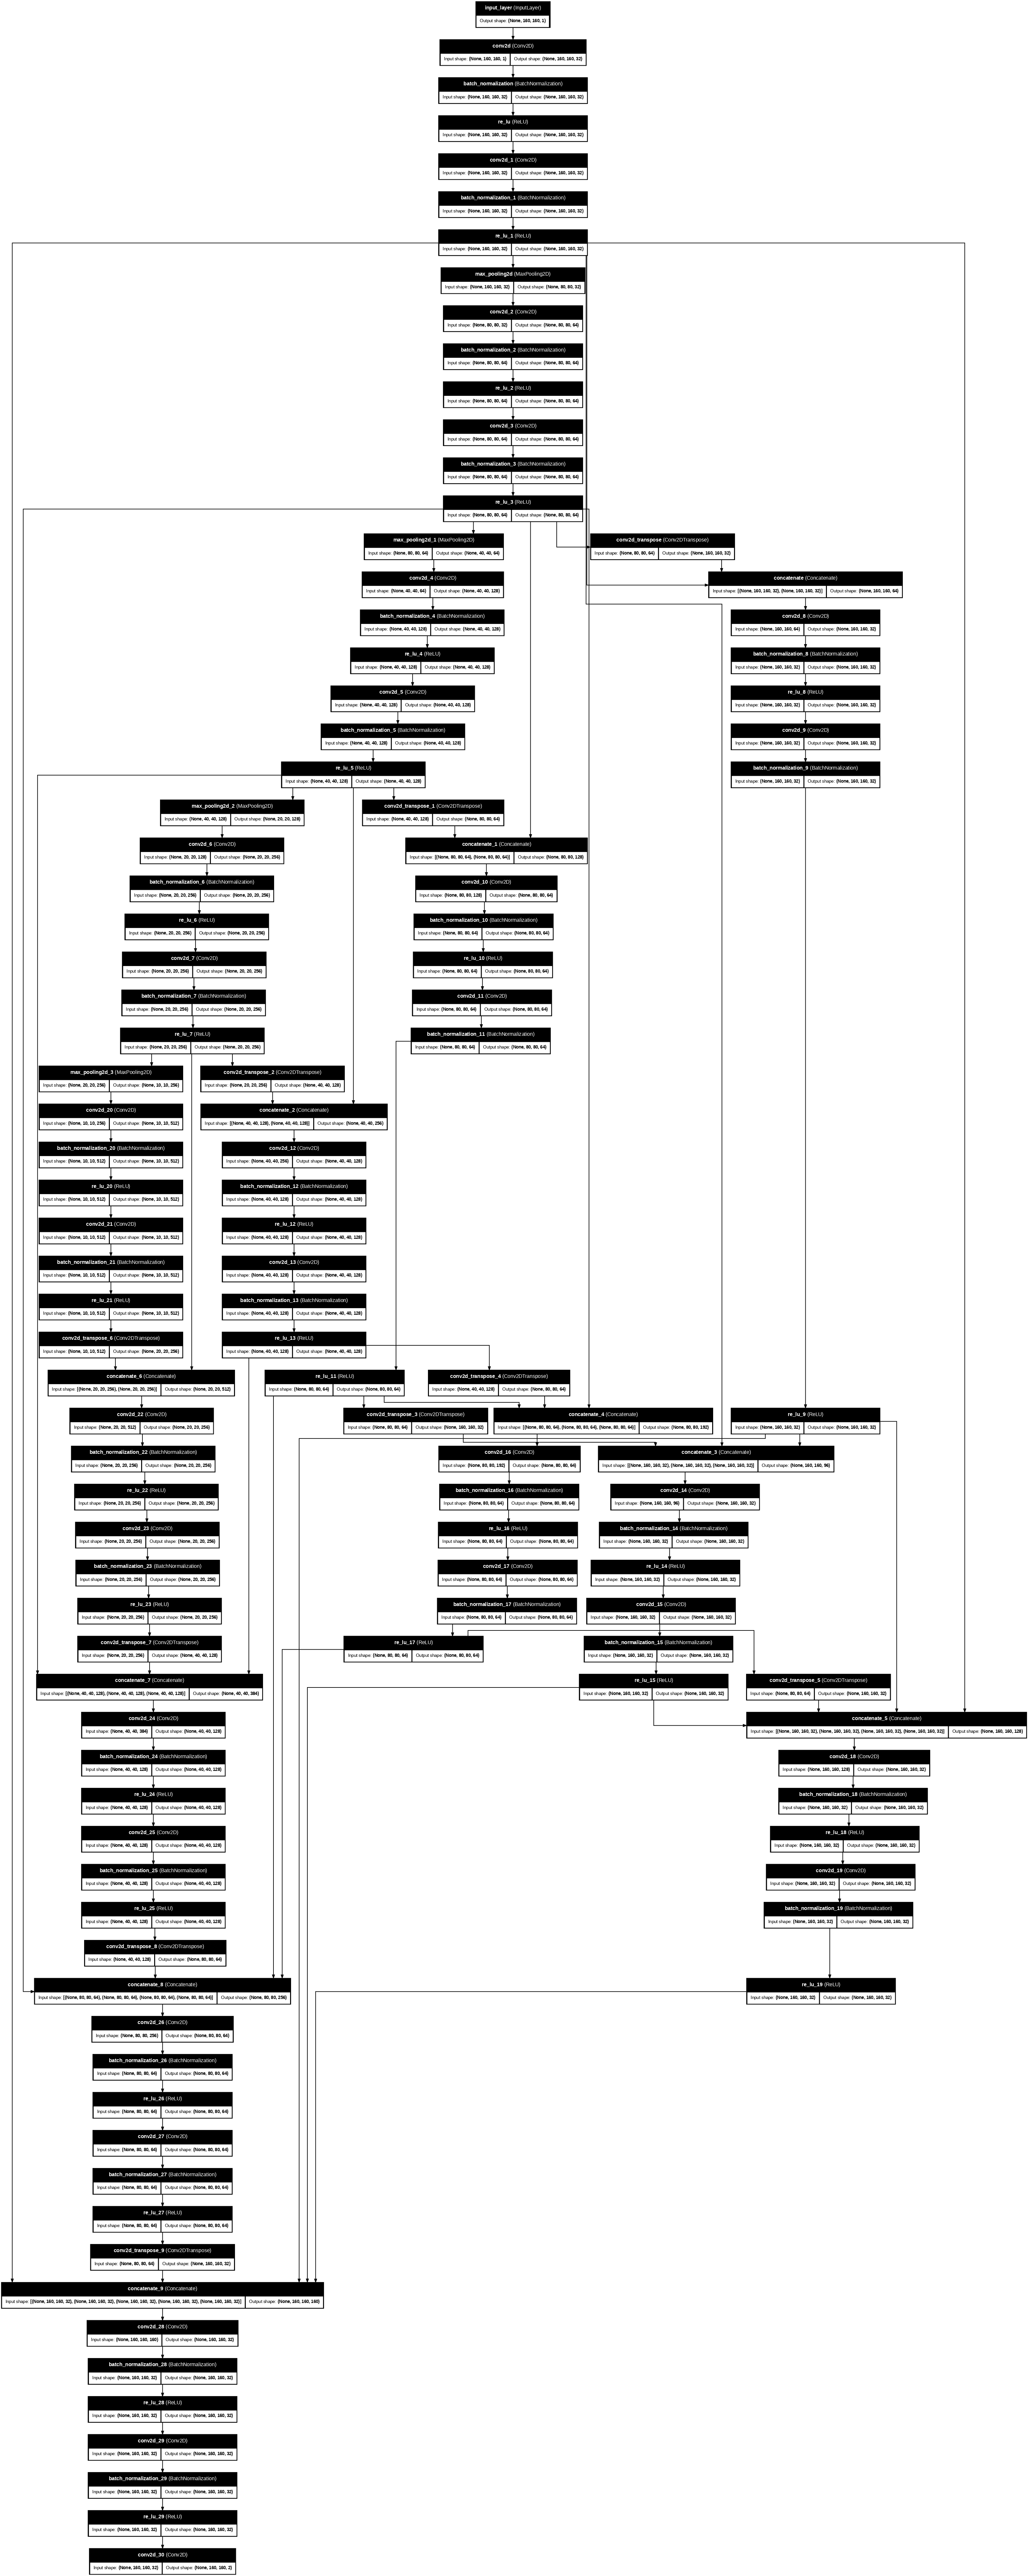

In [ ]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

In [ ]:
model.compile(
    optimizer=Adam() ,
    loss="categorical_crossentropy",
    metrics=['categorical_accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(monitor = "val_loss", save_best_only=True, filepath='best.keras'),
]

In [ ]:
epochs = 15
history = model.fit(train_data, epochs=epochs,validation_data=valid_data, callbacks=callbacks)

Epoch 1/15
     94/Unknown 363s 3s/step - categorical_accuracy: 0.8850 - loss: 0.2469

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


94/94 ━━━━━━━━━━━━━━━━━━━━ 397s 3s/step - categorical_accuracy: 0.8858 - loss: 0.2453 - val_categorical_accuracy: 0.4786 - val_loss: 2.0109
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - categorical_accuracy: 0.9894 - loss: 0.0288 - val_categorical_accuracy: 0.7474 - val_loss: 1.0062
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - categorical_accuracy: 0.9920 - loss: 0.0206 - val_categorical_accuracy: 0.9066 - val_loss: 0.2886
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - categorical_accuracy: 0.9932 - loss: 0.0170 - val_categorical_accuracy: 0.9673 - val_loss: 0.0987
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - categorical_accuracy: 0.9936 - loss: 0.0157 - val_categorical_accuracy: 0.9864 - val_loss: 0.0355
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - categorical_accuracy: 0.9940 - loss: 0.0144 - val_categorical_accuracy: 0.9935 - val_loss: 0.0160
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - categorical_accuracy: 0.9947 - loss: 0.0126 - val_ca

In [ ]:
model.load_weights('best.keras')

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0],cmap='gray')
    plt.imshow(display_list[i],cmap='gray',alpha=0.6)
    plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


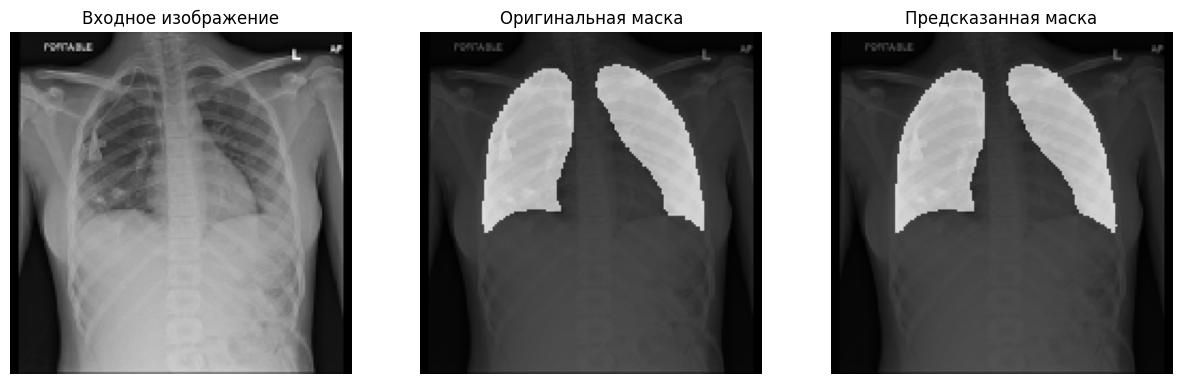

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


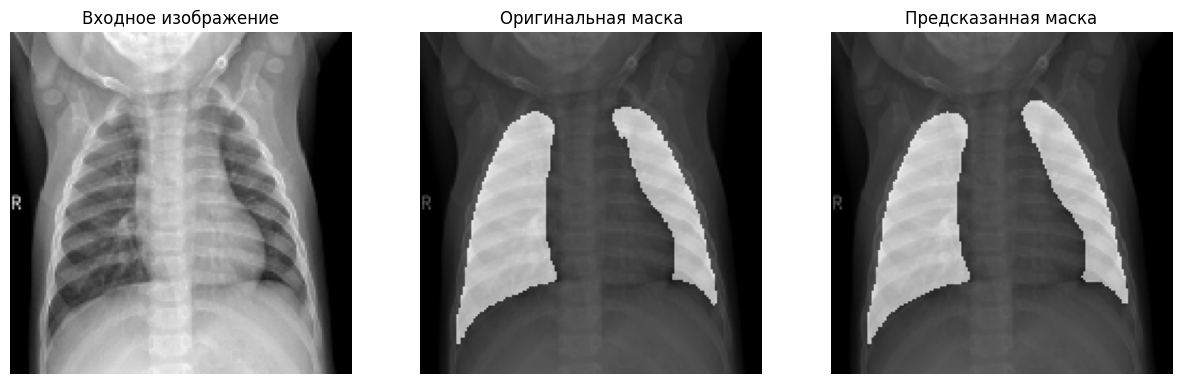

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


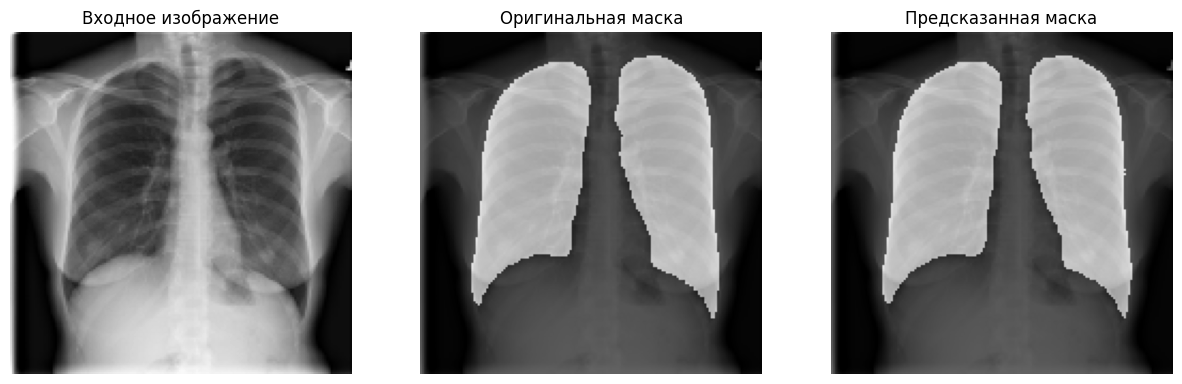

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


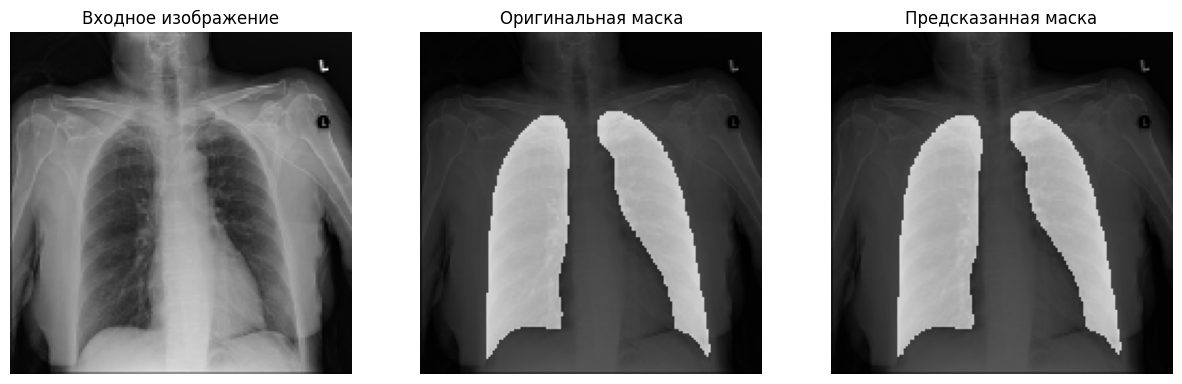

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


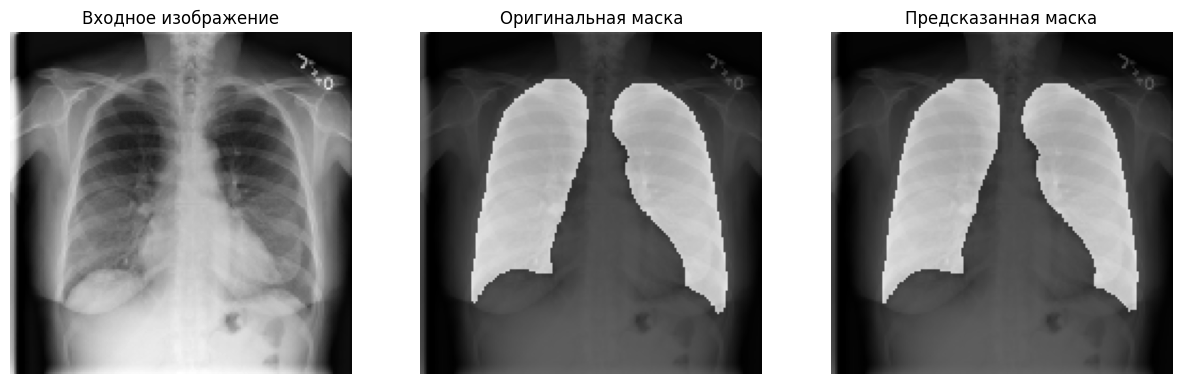

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


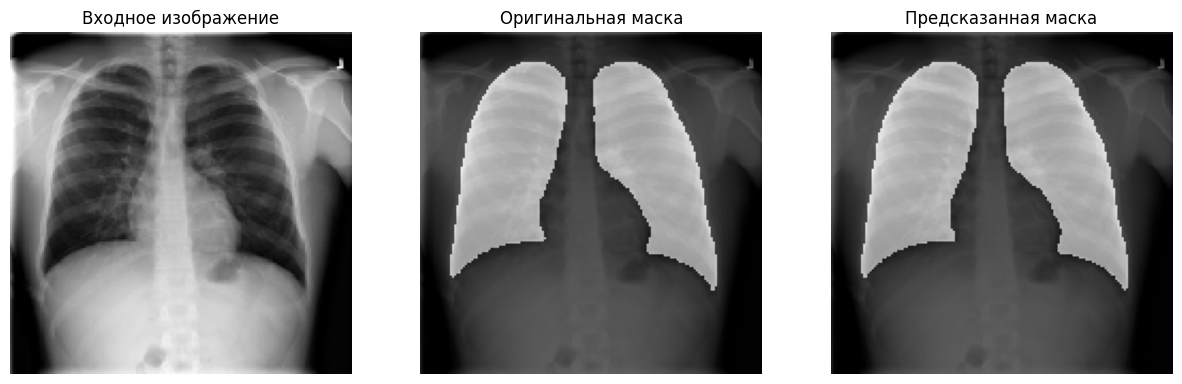

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


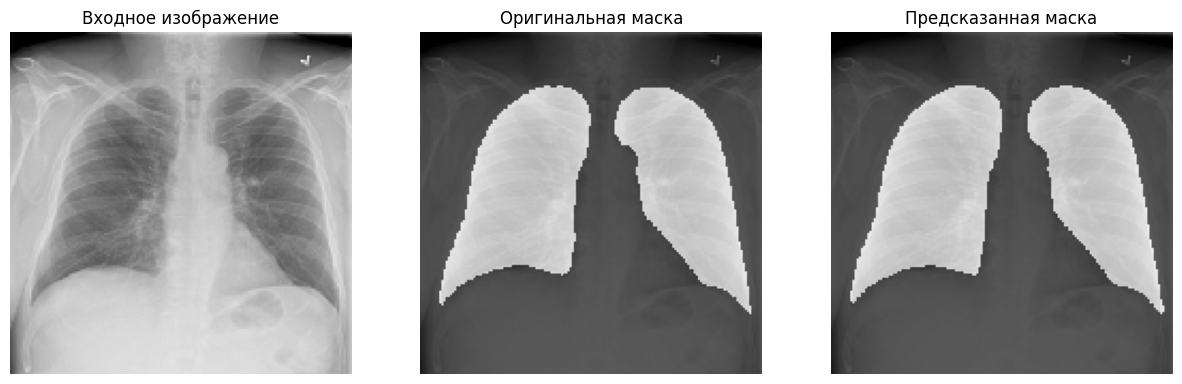

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


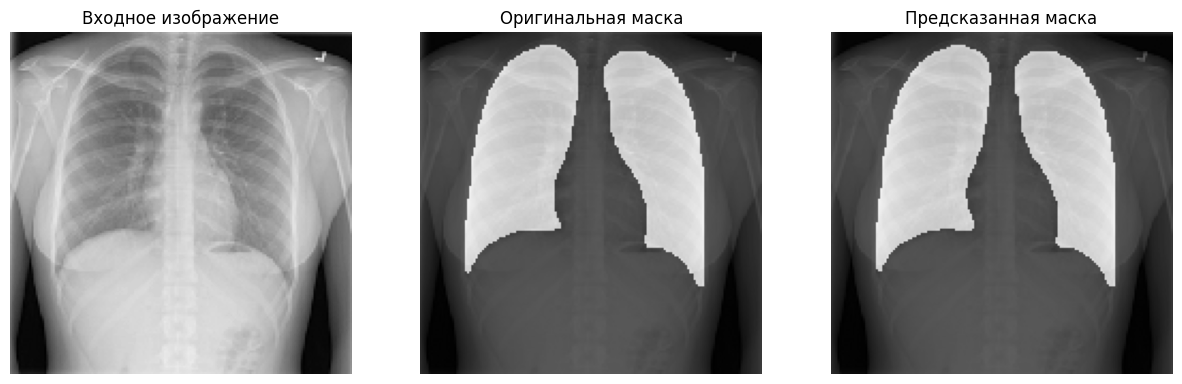

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


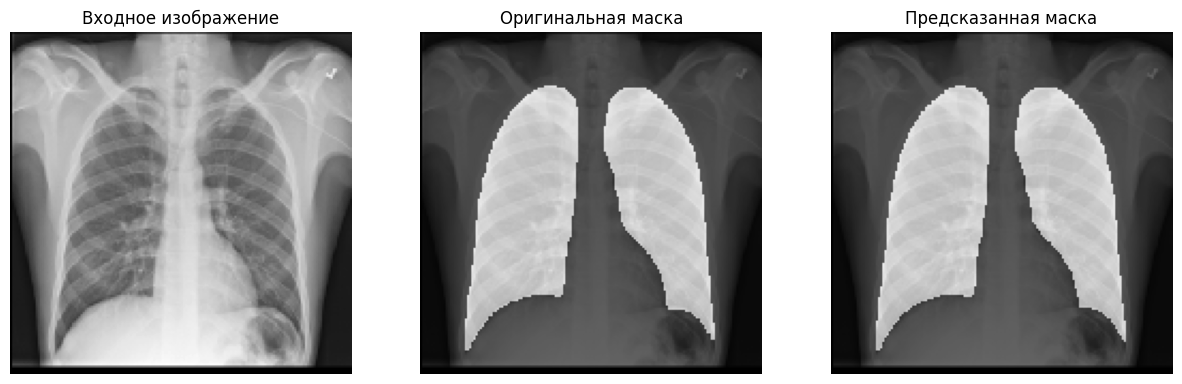

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


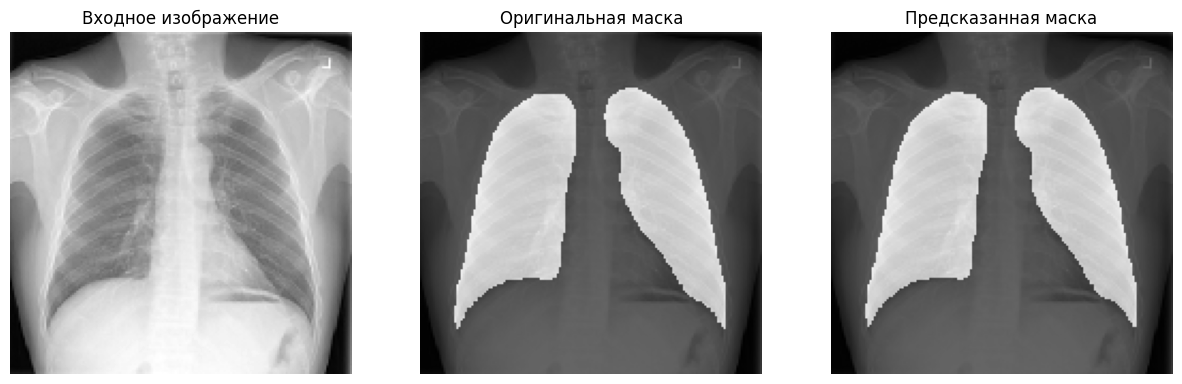

In [ ]:
for image in test:
    img = load_image(image,PATH_IMAGES)
    mask = load_image(image,PATH_MASKS)

    test_ = model.predict(np.expand_dims(img, 0))

    test_ = np.argmax(test_, axis=-1)

    display([img, mask, test_[0]])